### This notebook is a demonstration of how to use our topic model to:

1. Obtain topics
2. Visualize topic transition heat maps
3. Reproduce topic transition chain/graphs



In [84]:
# import dependencies
import sys

import matplotlib
import matplotlib.pyplot as plt
import random
import torch
from torch import nn, optim
from torch.autograd import Function
import numpy as np
import os
import pickle
import data_analysis_utils
from data_analysis_utils import (prepare_text_for_lda, read_from_json_export, tokenize_doc_list, build_reduced_glove_dict,
convert_token_2_ids, read_from_json_export_by_story, text_to_topic, compute_topic_transition_matrix, filtere_off_unk_topics)
from collections import Counter
import dae_model
from dae_model import DictionaryAutoencoder
import time

#### GPU required

In [85]:
device = 'cuda:0'

#### Fix random seed for python, numpy and torch to ensure reproducibility 

In [86]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

#### Load pretrained topic model and stored storium data

In [87]:
final_data_path = './final'



# pretrained model (the model is trained on pooled data of entries and challenges)
with open(os.path.join(final_data_path, 'model.pt'), 'rb') as f:
    model = torch.load(f, map_location=device)  # put the model on specified device
model.to(device)  # simply load without parallelism
model.device = device
model.eval()

# read the dictionary of entries and challenges pooled by story and then by worlds
with open( os.path.join(final_data_path, 'text_by_world_dict.pkl'), 'rb') as f:
    text_by_story_world_dict = pickle.load(f)
    

# read the saved vocab (word embedding + word2id dict) used by the topic model
embedding_matrix_np = np.load(os.path.join(final_data_path, 'embedding_matrix.npy'))
with open(os.path.join(final_data_path, 'word2id_dict.pkl'), 'rb') as f:
    word2id_dict = pickle.load(f)


    
# load the previously annotated world labels (and keep track of the unknown topics' id)
with open( os.path.join(final_data_path, 'topics_pooled.txt'), 'r') as f:
    lines = f.readlines()
topics_summarized = []
idx_filter_off = []
for idx, line in enumerate( lines ):
    line_split = line.strip().split(': ')[1]
    topics_summarized.append(line_split)
    if line_split[:3] == 'unk':
        idx_filter_off.append(idx)

        
# load the previously inferred topic transition matrices in each world
config = 'entry_by_character'
with open(os.path.join( final_data_path, f'topic_transition_matrix_by_world_dict_{config}.pkl'), 'rb') as f:
    topic_transition_matrix_by_world_dict = pickle.load(f)

# count the number of stories in each world
world_counter = Counter()
for world, stories in text_by_story_world_dict.items():
    world_counter.update({world: len(stories)})
    
print(f'Finished loading the model and text (from {len(text_by_story_world_dict)} worlds in total)')


Finished loading the model and text (from 59 worlds in total)


### Visualize the topics

In [88]:
model.rank_vocab_for_topics(word_embedding_matrix=embedding_matrix_np)

topic 0 : savory, garlic, dessert, hummus, pasta, ricotta, yogurt, cheese, salad, sauce
topic 1 : infection, toxic, attack, bacteria, killing, kill, mutant, poisoning, deadly, virus
topic 2 : stepmother, grandson, niece, sister, wife, father, mother, granddaughter, eldest, daughter
topic 3 : teacher, syllabus, coursework, college, graduate, curriculum, school, semester, student, undergraduate
topic 4 : olivie, endlos, herzen, soulreaver, pinggiran, executie, ongeval, unknownartist, laprop, ohhhhhhhhhhhhhhhhhhhh
topic 5 : grinning, quizzical, questioningly, frown, eyebrow, scowl, shyly, smile, grin, smirk
topic 6 : profit, investor, mortgage, timeshare, savings, broker, income, annuity, brokerage, buyer
topic 7 : sludge, compost, moisture, chlorine, sanitize, mildew, sewage, disinfect, water, wastewater
topic 8 : leather, drawstring, holster, jacket, placket, strap, waistband, collar, zipper, vest
topic 9 : supervising, safety, investigation, supervisory, counterintelligence, enforcemen

### Summarized topics

### Visualize the world

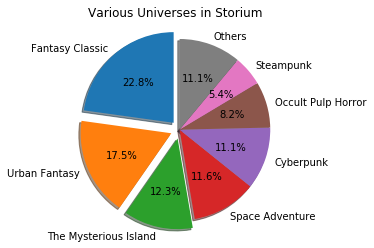

In [89]:
labels = []
sizes = []
size_remaining = 0

for idx, world_tuple in enumerate(world_counter.most_common()):
    if idx == 0:
        continue
    if idx <=7:
        labels.append(world_tuple[0])
        sizes.append(world_tuple[1])
    else:
        size_remaining += world_tuple[1]
labels.append('Others')
sizes.append(size_remaining)

explode = [0] * len(sizes)
explode[0] = 0.1
explode[1] = 0.1
explode[2] = 0.1

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Various Universes in Storium')
plt.show()

In [90]:
#### visualize the topic transition adjacency matrix in each world

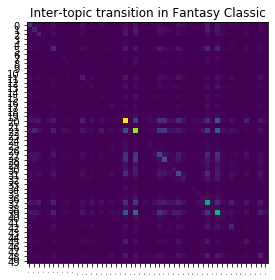

In [91]:

world_name = 'Fantasy Classic'
topic_transition_matrix = topic_transition_matrix_by_world_dict[world_name]

fig, ax = plt.subplots()
im = ax.imshow(topic_transition_matrix)

# We want to show all ticks...
num_topics = model.K
ax.set_xticks(np.arange(num_topics))
ax.set_yticks(np.arange(num_topics))

# # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", size=2,
             rotation_mode="anchor")


ax.set_title(f"Inter-topic transition in {world_name}")
fig.tight_layout()
plt.show()

In [92]:
# PLOT_SINGLE_CHAIN = True
def plot_single_chain(starting):
    starting_topic = topics_summarized[starting]
#     if starting_topic[:3]== 'unk':
#         continue
    print(f'Starting from topic {starting} {topics_summarized[starting]}: ')
    for idx, (world_name, _) in enumerate(world_counter.most_common()):
        if idx == 0:
            continue
        topic_transition_matrix = topic_transition_matrix_by_world_dict[world_name]
        topic_transition_matrix = filtere_off_unk_topics(topic_transition_matrix, idx_filter_off)


        # traverse through topic transition matrix
        track = []

        next = starting
        track.append(next)
        while len(track) < 4:
            all_candidates = topic_transition_matrix[next]
            desc_order = np.argsort(all_candidates)
            if next == desc_order[-1]:
                next = desc_order[-2]
            else:
                next = desc_order[-1] # -2 because the highest probability other than the diagonal
            track.append(next)

        track_str = []
        for i in track:
            track_str.append(topics_summarized[i])
        # print(f'In the world {world_name}, starting from {topics_summarized[starting]}:')
        print(f'[{world_name}]: ' + ' --> '.join(track_str))
        print()

        if idx >= 7:
            break
            
            
def plot_divergence(starting):

    starting_topic = topics_summarized[starting]

    print(f'Starting from topic {starting} {topics_summarized[starting]}: ')
    for idx, (world_name, _) in enumerate(world_counter.most_common()):
        if idx == 0:
            continue
        topic_transition_matrix = topic_transition_matrix_by_world_dict[world_name]
        topic_transition_matrix = filtere_off_unk_topics(topic_transition_matrix, idx_filter_off)

        all_candidates = topic_transition_matrix[starting]
        desc_order = np.argsort(all_candidates)

        top_3 = desc_order[-3:]

        if starting in top_3:
            indx_of_starting = np.where( top_3 == starting)[0][0]
            top_2 = np.delete(top_3, indx_of_starting)
        else:
            top_2 = top_3[-2:]

        top_2_words = [topics_summarized[i] for i in top_2 ]
        top_2_str = ' ' + ' | '.join(top_2_words) + ' '
        print(f'[{world_name}]: '+ f' {topics_summarized[starting]} '  + ' --> ' + top_2_str)

        if idx >= 7:
            break

### Looking at single chain transition

In [93]:
# Starting from topic 0 food
plot_single_chain(0)

Starting from topic 0 food: 
[Fantasy Classic]: food --> color in nature/wilderness --> sorcery --> color in nature/wilderness

[Urban Fantasy]: food --> sex scenes --> meeting schedule --> food

[The Mysterious Island]: food --> color in nature/wilderness --> wail and shrill --> color in nature/wilderness

[Space Adventure]: food --> female names --> male names --> mechanical systems

[Cyberpunk]: food --> color in nature/wilderness --> mechanical systems --> information

[Occult Pulp Horror]: food --> male names --> female names --> male names

[Steampunk]: food --> male names --> objection and condemnation --> male names



In [94]:
# Starting from topic 1 infection: 
plot_single_chain(1)

Starting from topic 1 infection: 
[Fantasy Classic]: infection --> sorcery --> color in nature/wilderness --> sorcery

[Urban Fantasy]: infection --> wail and shrill --> color in nature/wilderness --> information

[The Mysterious Island]: infection --> beliefs --> color in nature/wilderness --> wail and shrill

[Space Adventure]: infection --> mechanical systems --> male names --> mechanical systems

[Cyberpunk]: infection --> information --> male names --> mechanical systems

[Occult Pulp Horror]: infection --> information --> male names --> female names

[Steampunk]: infection --> mechanical systems --> expedition --> color in nature/wilderness



In [95]:
#Starting from topic 9 security and surveillance: 
plot_single_chain(9)

Starting from topic 9 security, surveillance: 
[Fantasy Classic]: security, surveillance --> color in nature/wilderness --> sorcery --> color in nature/wilderness

[Urban Fantasy]: security, surveillance --> information --> objection and condemnation --> information

[The Mysterious Island]: security, surveillance --> color in nature/wilderness --> wail and shrill --> color in nature/wilderness

[Space Adventure]: security, surveillance --> mechanical systems --> male names --> mechanical systems

[Cyberpunk]: security, surveillance --> information --> male names --> mechanical systems

[Occult Pulp Horror]: security, surveillance --> wail and shrill --> male names --> female names

[Steampunk]: security, surveillance --> mechanical systems --> expedition --> color in nature/wilderness



### Looking at top 2 topics

In [99]:
#Starting from topic 48 information:
plot_divergence(48)

Starting from topic 48 information: 
[Fantasy Classic]:  information  -->  sorcery | color in nature/wilderness 
[Urban Fantasy]:  information  -->  female names | objection and condemnation 
[The Mysterious Island]:  information  -->  village and tourism | color in nature/wilderness 
[Space Adventure]:  information  -->  male names | mechanical systems 
[Cyberpunk]:  information  -->  mechanical systems | male names 
[Occult Pulp Horror]:  information  -->  color in nature/wilderness | male names 
[Steampunk]:  information  -->  male names | objection and condemnation 


In [100]:
# Starting from topic 28 combat and war: 
plot_divergence(28)

Starting from topic 28 combat and war: 
[Fantasy Classic]:  combat and war  -->  color in nature/wilderness | sorcery 
[Urban Fantasy]:  combat and war  -->  sorcery | color in nature/wilderness 
[The Mysterious Island]:  combat and war  -->  expedition | male names 
[Space Adventure]:  combat and war  -->  male names | mechanical systems 
[Cyberpunk]:  combat and war  -->  objection and condemnation | mechanical systems 
[Occult Pulp Horror]:  combat and war  -->  information | color in nature/wilderness 
[Steampunk]:  combat and war  -->  expedition | mechanical systems 


In [103]:
# Starting from topic 19 expedition: 
plot_divergence(19)

Starting from topic 19 expedition: 
[Fantasy Classic]:  expedition  -->  sorcery | color in nature/wilderness 
[Urban Fantasy]:  expedition  -->  female names | color in nature/wilderness 
[The Mysterious Island]:  expedition  -->  color in nature/wilderness | male names 
[Space Adventure]:  expedition  -->  color in nature/wilderness | mechanical systems 
[Cyberpunk]:  expedition  -->  surgery and amputation | male names 
[Occult Pulp Horror]:  expedition  -->  information | color in nature/wilderness 
[Steampunk]:  expedition  -->  male names | color in nature/wilderness 
